In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import os
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import skimage.io
import pandas as pd

#### Let's download dataset Labeled Faces in the Wild

In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [3]:
all_photos, all_attrs = fetch_dataset()
all_photos = all_photos.astype(np.float32)

#### Now let's make a simple VAE that consists of linear layers.
We will also describe the parameterize method, which converts from a random variable with mean 0 and standard deviation 1 to an arbitrary normal random variable. In this way we can generate a latent vector from an arbitrary normal distribution

In [ ]:
features = 16
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.flatten = nn.Flatten()

        self.Encoder = nn.Sequential(
            nn.Linear(64 * 64 * 3, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, features * 2)
        )

        self.Decoder = nn.Sequential(
            nn.Linear(features, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 64 * 64 * 3)
        )
    

    def parameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.rand_like(std)
        sample = (eps * std) + mu
        return sample
    
    def get_latent(self, x):
        x = self.flatten(x).float()
        x = self.Encoder(x).view(-1, 2, features)
        mu = x[:, 0, :]
        log_var = x[:, 1, :]
        z = self.parameterize(mu, log_var)
        return z, mu, log_var

    def sample(self, z):
        z = self.Decoder(z)
        z = torch.sigmoid(z)
        z = z.view(-1, 64, 64 ,3)
        return z

    def forward(self, x):
        z, mu, log_var = self.get_latent(x)
        z = self.Decoder(z)
        z = torch.sigmoid(z)
        return z, mu, log_var

Loss for VAE consists of several parts, these are KL-divergence, which is responsible for how far apart the distributions corresponding to different individuals are, and log-likelihood, which is responsible for how much efficient coding we applied
The total loss will look like this:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

KL-divergence:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

As log-likelihood we take the cross-entropy.

In [5]:
def KL_divergence(mu, log_sigm):
    return - torch.sum(1 + log_sigm - mu.pow(2) - log_sigm.exp()) / 2


def log_likelihood(x, reconstruction):
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def VAE_loss(x, mu, log_sigm, reconstruction):
    return KL_divergence(mu, log_sigm) + log_likelihood(x, reconstruction)

In [6]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
criterion = VAE_loss

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 3e-4, amsgrad=True)

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(all_photos, all_attrs,
                                                                    train_size=0.9, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_photos, batch_size=32, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=32, pin_memory=True)

In [8]:
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        reconstruction, mu, logsigma = model(batch.to(device))
        reconstruction = reconstruction.view(-1, 64, 64, 3)
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_loader:
          reconstruction, mu, logsigma = model(batch.to(device))
          reconstruction = reconstruction.view(-1, 64, 64, 3)
          loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/50 [00:00<?, ?it/s]

#### Let's check how our VAE encode and decode pictures

In [9]:
model.eval()
with torch.no_grad():
    for batch in val_loader:
        reconstruction, mu, logsigma = model(batch.to(device))
        reconstruction = reconstruction.view(-1, 64, 64, 3)
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch.numpy()
        break

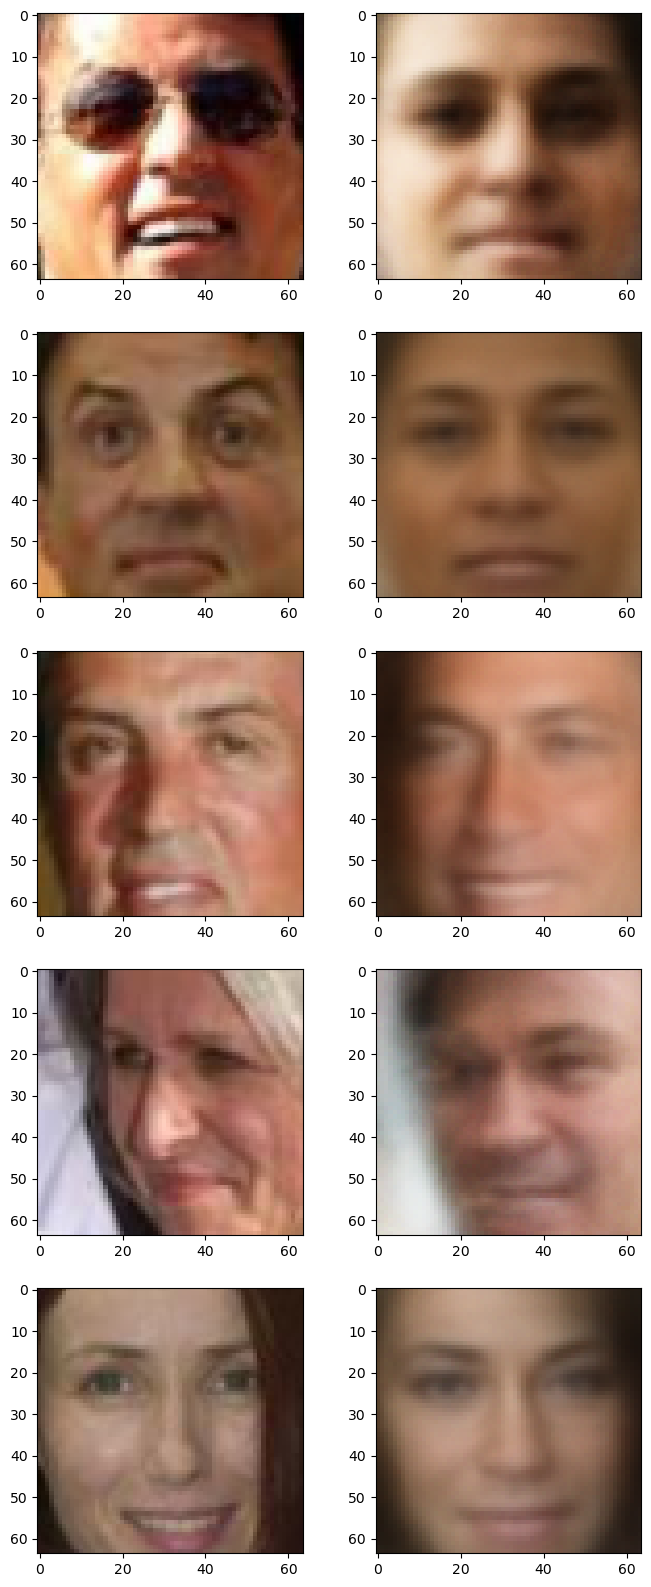

In [10]:
plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(gt)
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(res)

#### Sampling
Let's give decoder random vector from normal distribution and see what kind of pictures we get. 

In [11]:
z = np.array([np.random.normal(0, 1, 16) for i in range(10)])
output = model.sample(torch.FloatTensor(z).to(device))

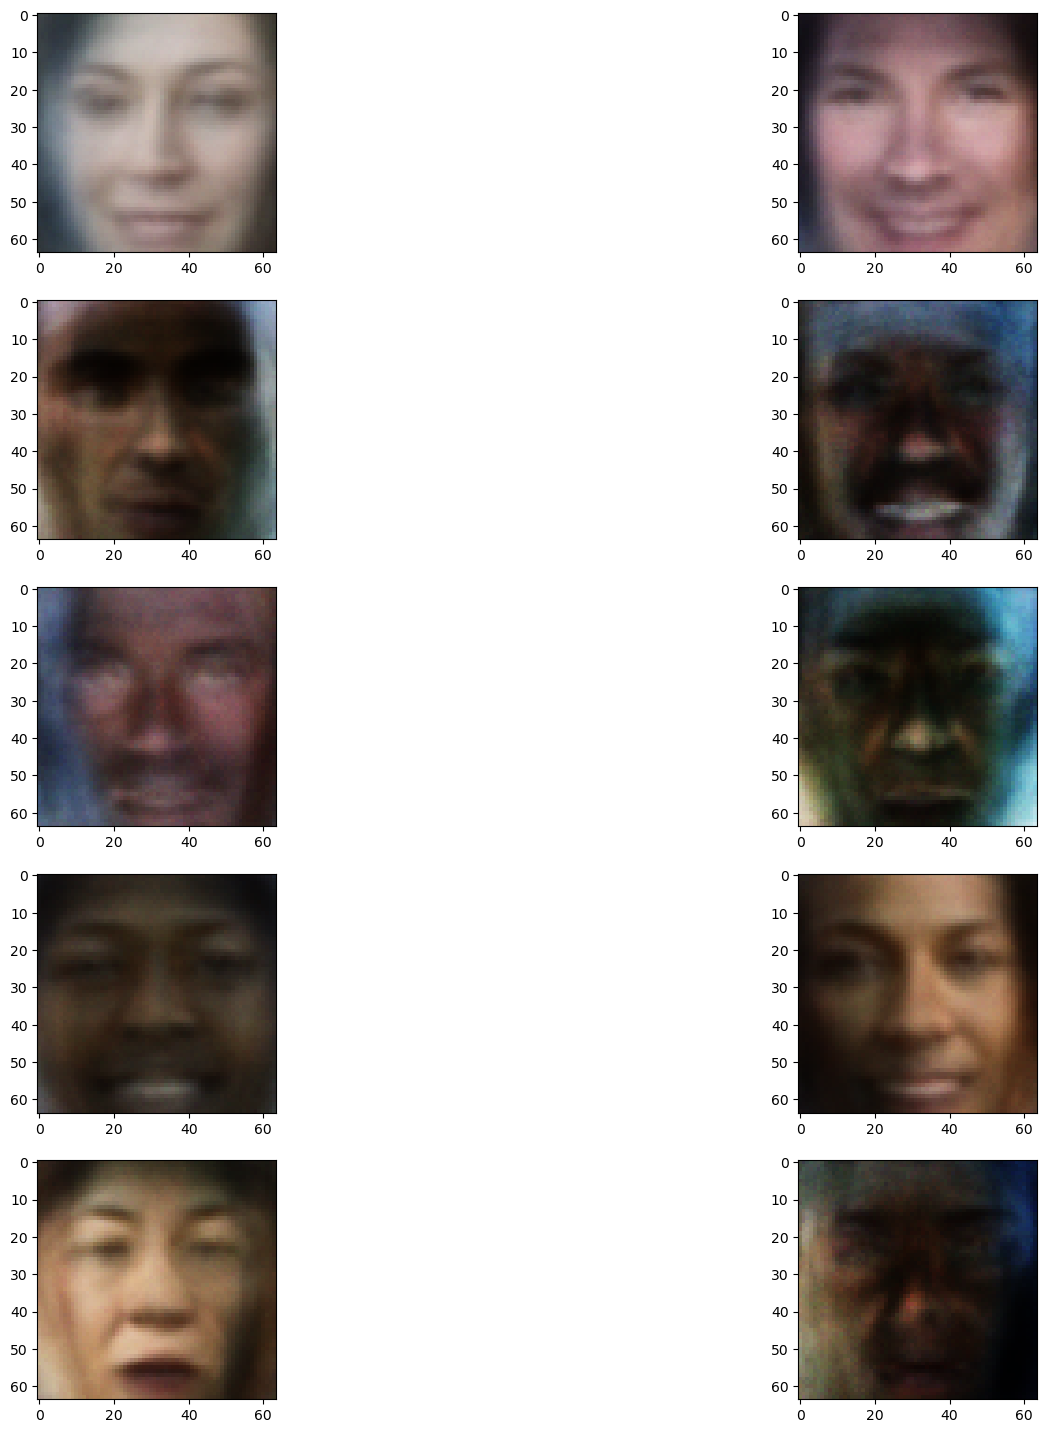

In [12]:
plt.figure(figsize=(18, 18))
for i in range(output.shape[0]):
    plt.subplot(output.shape[0] // 2, 2, i + 1)
    generated = output[i].cpu().detach().numpy()
    plt.imshow(generated)

plt.show()

#### Now let's generate two latent vectors and get $\alpha l_1 + (1 - \alpha)l_2$, where $l_1, l_2$ latent vectors

In [32]:
gt_0 = torch.FloatTensor(ground_truth[0]).unsqueeze(dim=0).to(device)
gt_1 = torch.FloatTensor(ground_truth[1]).unsqueeze(dim=0).to(device)

In [34]:
first_latent_vector = model.get_latent(gt_0)[0]
second_latent_vector = model.get_latent(gt_1)[0]

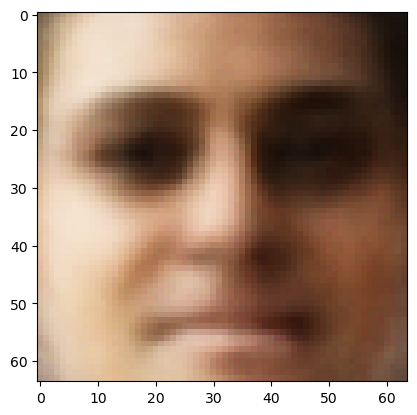

In [38]:
plt.imshow(model.sample(first_latent_vector)[0].cpu().detach().numpy());

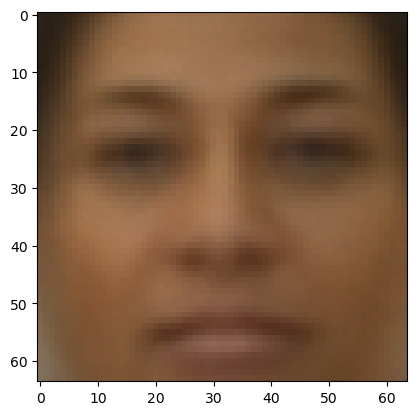

In [39]:
plt.imshow(model.sample(second_latent_vector)[0].cpu().detach().numpy());

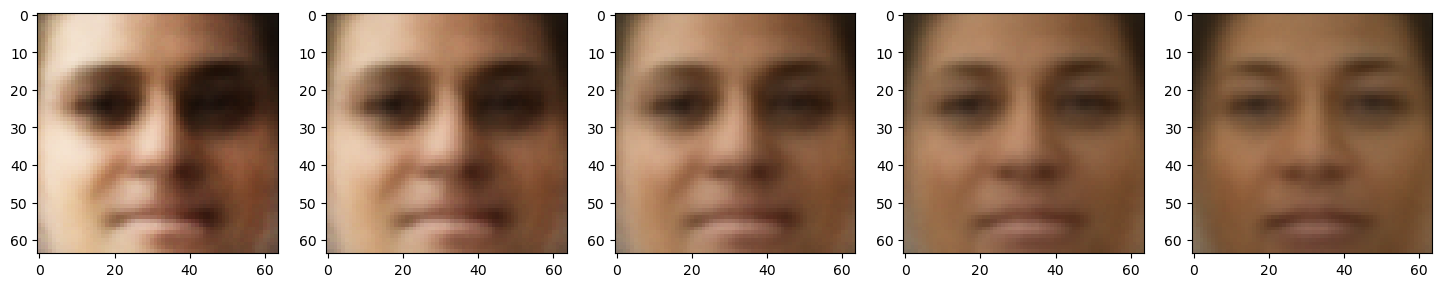

In [40]:
plt.figure(figsize=(18, 5))
for i, alpha in enumerate(np.linspace(0., 1., 5)):
    plt.subplot(1, 5, i + 1)
    latent = (1 - alpha) * first_latent_vector + alpha * second_latent_vector
    img = model.sample(latent)[0].cpu().detach().numpy()
    plt.imshow(img)